# Fit a Gaussian profile to lines with MCMC

In the last notebook we explored the data through quantifying **line strengths** by eye.  In this notebook we will use a probabilistic computational technique called [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to fit a Gaussian to spectral lines in HPF data.  The area under the curve of the Gaussian will then represent the line line strength.

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

In [109]:
goldilocks_files = glob.glob('C:/Users/jojoa/GitHub/disperse/data/HPF/Helium-transit-data/**/Goldilocks*.fits', recursive=True)

In [110]:
def get_goldilocks_dataframe(fn):
    """Return a pandas Dataframe given a Goldilocks FITS file name"""
    hdus = fits.open(fn)
    df_original = pd.DataFrame()
    for j in range(28):
        df = pd.DataFrame()
        for i in range(1, 10):
            name = hdus[i].name
            df[name] = hdus[i].data[j, :]
        df['order'] = j
        df_original = df_original.append(df, ignore_index=True)
    keep_mask = df_original[df_original.columns[0:6]] != 0.0
    df_original = df_original[keep_mask.all(axis=1)].reset_index(drop=True)
    
    return df_original

In [111]:
def normalize_spectrum(df):
    """Normalizes spectrum to set to one"""
    for order in df.order.unique():
        mask = df.order == order
        norm_constant = df['Sci Flux'][mask].median() #mean takes outliers into account
        df['Sci Flux'][mask] = df['Sci Flux'][mask]/norm_constant
        df['Sci Error'][mask] = df['Sci Error'][mask]/norm_constant
        
    return df

In [126]:
index = 294 # Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [127]:
print (fn)

C:/Users/jojoa/GitHub/disperse/data/HPF/Helium-transit-data\HAT-P-67b\in-transit\20200615\Goldilocks_20200615T034120_v1.0_0028.spectra.fits


In [128]:
%%capture
df = normalize_spectrum(get_goldilocks_dataframe(fn))

In [129]:
df.groupby('order').mean() #not exactly one because dividing by median

,Sci Flux,Sky Flux,Cal Flux,Sci Error,Sky Error,Cal Error,Sci Wavl,Sky Wavl,Cal Wavl
order,,,,,,,,,
0,0.927329,0.029548,0.036663,0.018522,0.075058,0.075673,8134.276538,8134.274039,8134.271143
1,0.926111,0.057372,0.007664,0.017818,0.075966,0.075293,8244.199803,8244.197154,8244.194269
2,0.973088,0.038668,0.027034,0.019309,0.075985,0.075805,8357.135401,8357.132606,8357.129770
3,1.157679,0.006854,0.035442,0.027249,0.075669,0.076330,8473.205187,8473.202265,8473.199576
4,0.894019,0.053823,0.021743,0.014693,0.076263,0.075791,8592.547123,8592.544032,8592.541290
5,0.945955,0.048419,-0.003356,0.014595,0.076269,0.075564,8715.299103,8715.295854,8715.293125
6,0.937234,0.061496,0.036442,0.013799,0.076424,0.076223,8841.608370,8841.605144,8841.602254
7,0.940926,0.044850,0.014357,0.014437,0.076262,0.075990,8971.695373,8971.691965,8971.689028
8,0.945747,0.025644,0.002377,0.014201,0.075889,0.075770,9105.538131,9105.534630,9105.531828


In [130]:
df.describe()

,Sci Flux,Sky Flux,Cal Flux,Sci Error,Sky Error,Cal Error,Sci Wavl,Sky Wavl,Cal Wavl,order
count,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000
mean,0.967536,0.245824,0.019834,0.014001,0.079132,0.076541,10096.918205,10096.914615,10096.911884,13.502172
std,0.359937,2.136896,0.120355,0.004821,0.020229,0.002955,1355.215860,1355.215300,1355.215540,8.079234
min,-0.023835,-0.537520,-1.357702,0.002450,0.062925,0.064878,8079.274245,8079.278406,8079.263591,0.000000
25%,0.815041,-0.039912,-0.060176,0.011091,0.074512,0.074520,8894.619317,8894.611063,8894.616983,6.000000
50%,1.000000,0.045669,0.018225,0.012534,0.076424,0.076294,9934.861141,9934.862930,9934.851933,14.000000
75%,1.134588,0.138353,0.096546,0.016024,0.078700,0.078269,11222.384404,11222.383734,11222.378298,21.000000
max,4.397786,117.658661,5.419775,0.039986,0.680566,0.231808,12785.571300,12785.570453,12785.560327,27.000000


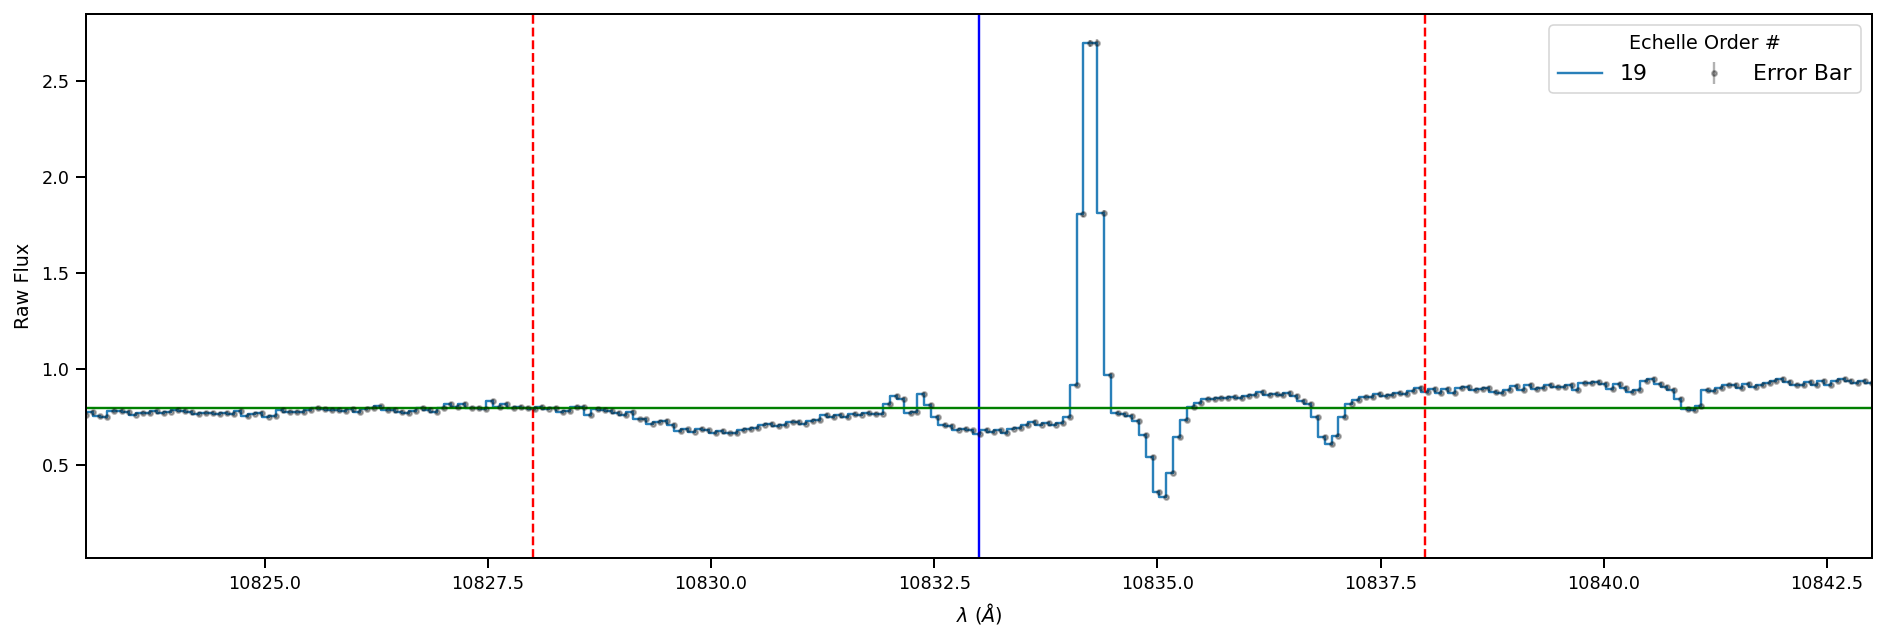

In [131]:
plt.figure(figsize=(16, 5))
order = 19
helium_line = 10833
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
#plt.ylim(0,0.8)
wavelength1 = helium_line-5
wavelength2 = helium_line+5
continuum = 0.8
plt.xlim(wavelength1-5,wavelength2+5)
plt.axvline(helium_line,color = 'blue')
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

Ok, let's fit a model to this data.  The model will consist of a straight-line trend with a Gaussian subtracted from it.  It will have five parameters, the straight-line trend slope $m$ and offset $b$, and the Gaussian amplitude $A$, center wavelength $\mu$, and width $w$.  
$$f_\lambda(m, b, A, \mu, w)= m \lambda +b - A\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

Let's focus on the **sub-region** set by the above plot.

$$f_\lambda(m, b, A, \mu, w)= 1 - \frac{A}{(m \mu + b)}\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

In [132]:
sub_region = (df.order == order) & (df['Sci Wavl'] > wavelength1) & (df['Sci Wavl'] < wavelength2)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [133]:
def generative_model(m, b, A, mu, logw, int_wl = helium_line):
    """Generate the model given parameters"""
    continuum = m * (wl - int_wl) + b
    w = np.exp(logw)
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return continuum - gaussian

Let's make an initial guess.

In [134]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0, continuum, 0.15, helium_line, np.log(0.6)

In [135]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

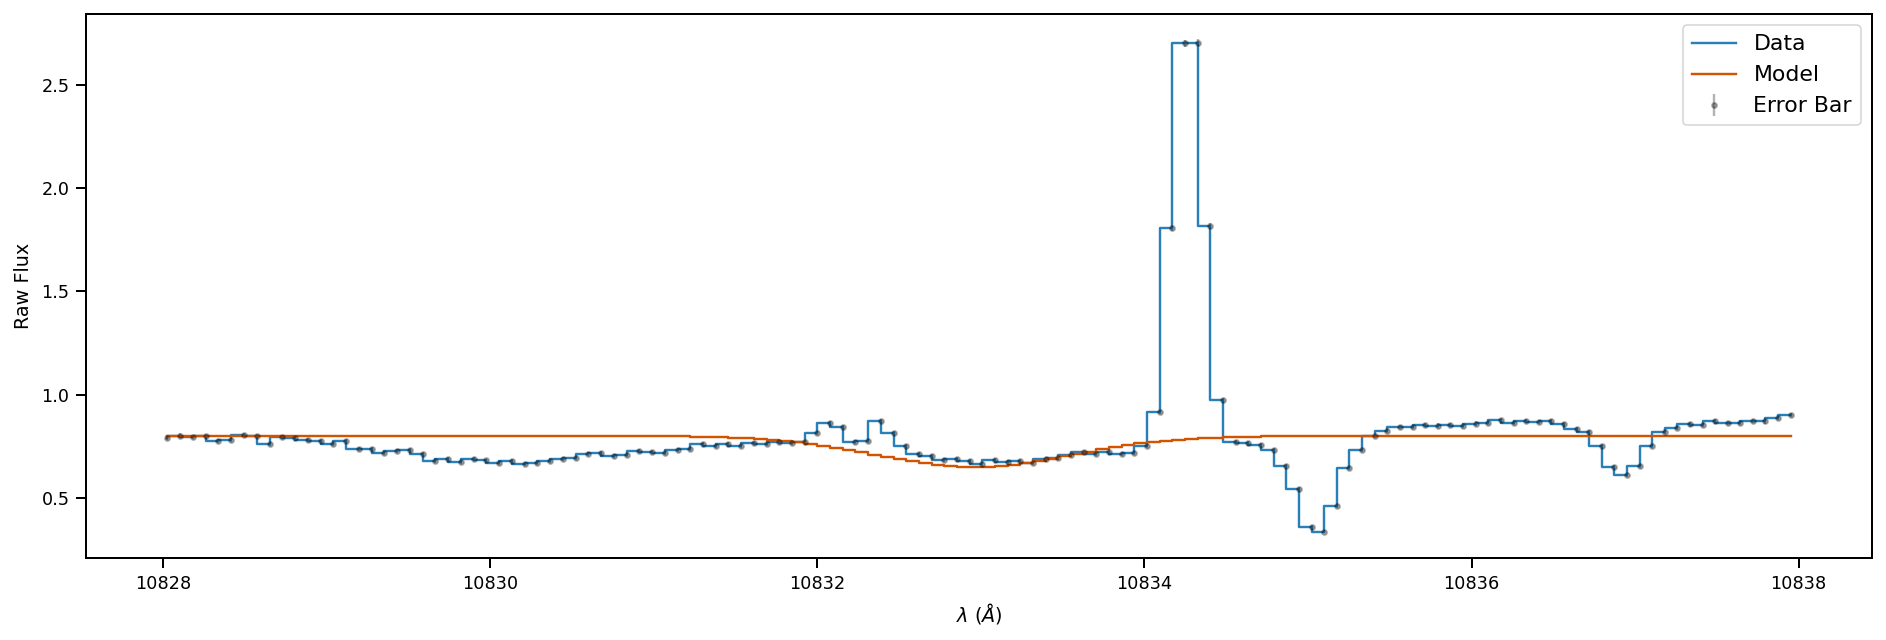

In [136]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
#plt.plot(wl, normalization);
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
#plt.ylim(.9,1.3)

The guess is *close* but not perfect-- the line center is slightly off.  That's OK!  Let's use MCMC to fine tune these parameters, and tell us the uncertainty in the parameter values.  We will use [emcee](https://emcee.readthedocs.io/en/stable/).

In [137]:
import emcee

We need to compute the log likelihood of the data, which takes in the parameters and returns a scalar "quality of fit metric".  Here we use *chi squared*, the sum of the squares of the residuals, weighted by their uncertainties.

In [138]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = helium_line)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [139]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess)

-25597.469188423674

In [140]:
n_walkers = 32
n_params = 5

In [141]:
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params) #intial guess position

In [142]:
n_steps = 5000

In [143]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 398.68it/s]


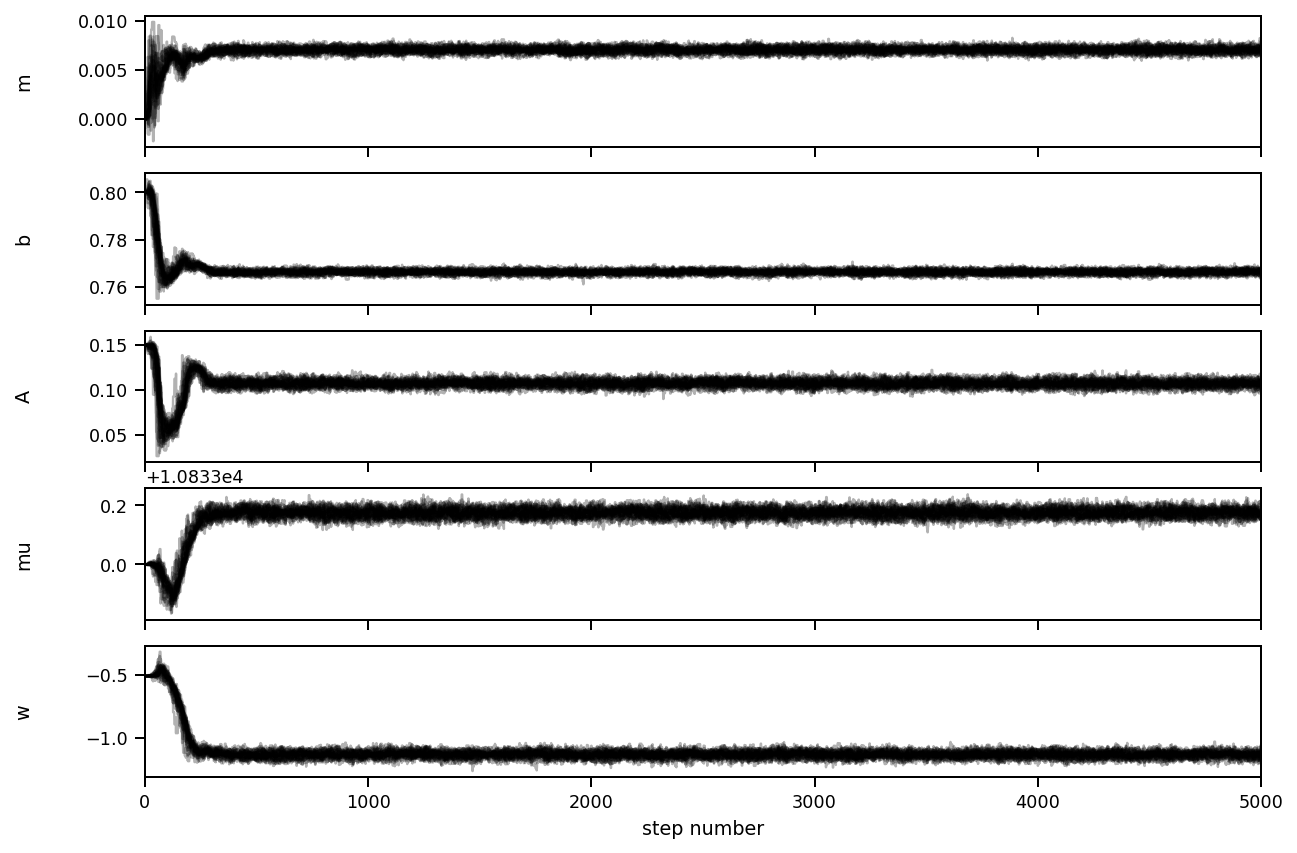

In [144]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [145]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(8512, 5)


In [146]:
ndim = 5

In [147]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [148]:
A_draws = samples[2000:, :, 2].reshape(-1)
b_draws = samples[2000:, :, 1].reshape(-1)
m_draws = samples[2000:, :, 0].reshape(-1)
mu_draws = samples[2000:, :, 3].reshape(-1)
w_draws = np.exp(samples[2000:, :, 4].reshape(-1))

Calculate the equivalent width from the MCMC samples.

In [149]:
m_fit, b_fit, A_fit, mu_fit, w_fit = flat_samples[3912, :]

In [150]:
good_fit = generative_model(m_fit, b_fit, A_fit, mu_fit, w_fit, int_wl = helium_line)

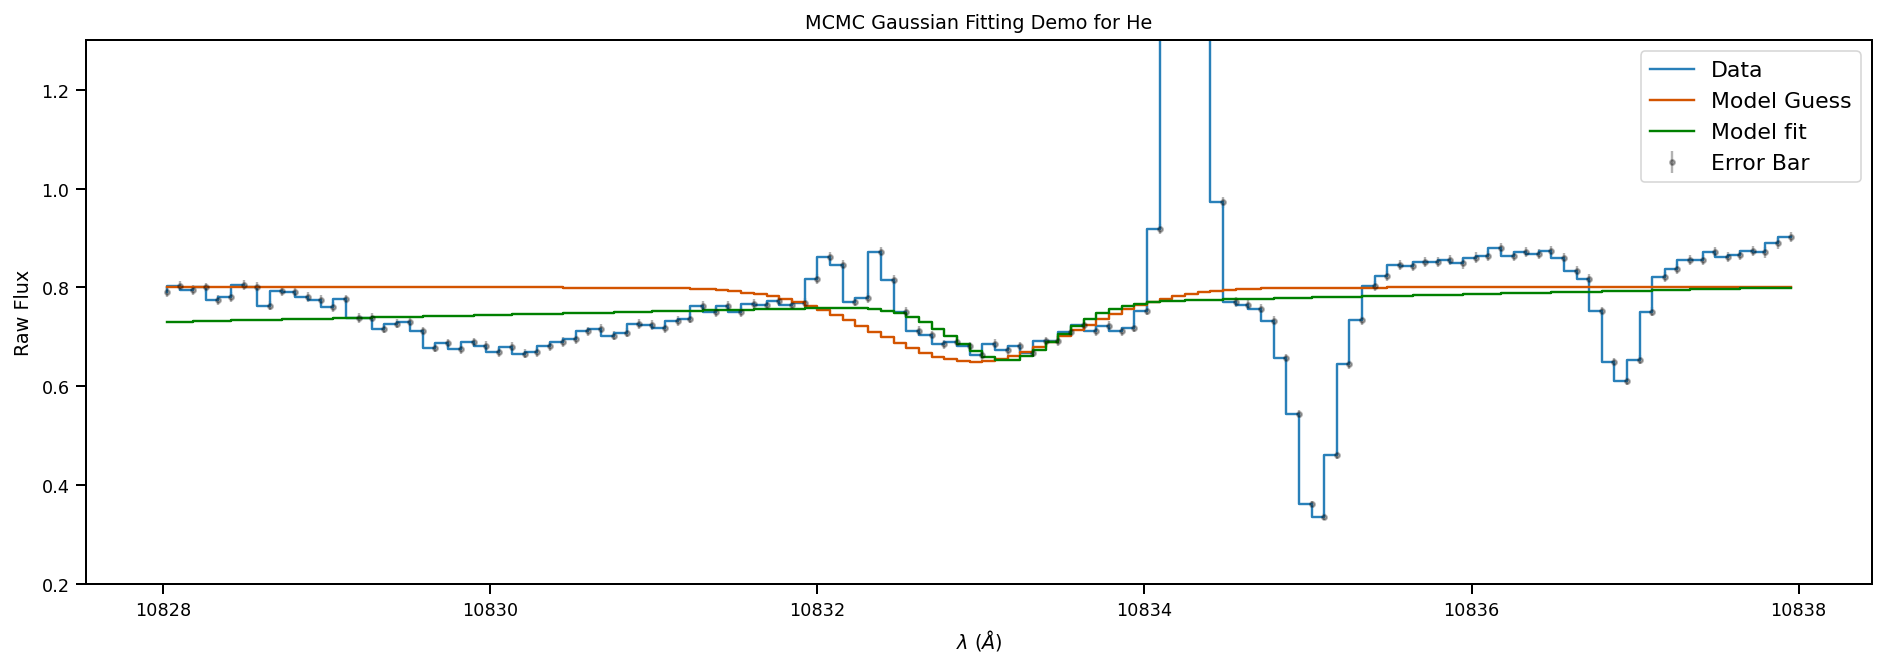

In [156]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model Guess', color='#d35400');
plt.step(wl, good_fit, label='Model fit', color='green');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(.2,1.3)
plt.title('MCMC Gaussian Fitting Demo for He')
plt.savefig('C:/Users/jojoa/GitHub/disperse/figures/MCMC_fig_He',bbox_inches="tight")

In [44]:
EW = ((2*np.pi)**.5)*(A_draws*w_draws)/(m_draws*(mu_draws-helium_line)+b_draws)
EW

array([0.0898405 , 0.09226251, 0.08798182, ..., 0.09438274, 0.10090077,
       0.06749617])

1.0671935978738833
0.021667062726685452


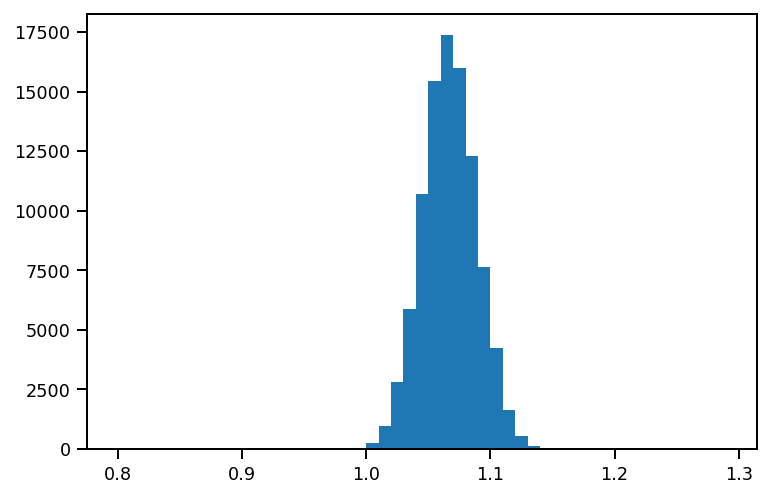

In [126]:
plt.hist(EW, bins = np.arange(0.8, 1.3, 0.01));
ew_mean = np.mean(EW)
ew_std = np.std(EW)
print(ew_mean)
print(ew_std)

In [127]:
index = 130 # Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [52]:
%%capture
df = normalize_spectrum(get_goldilocks_dataframe(fn))

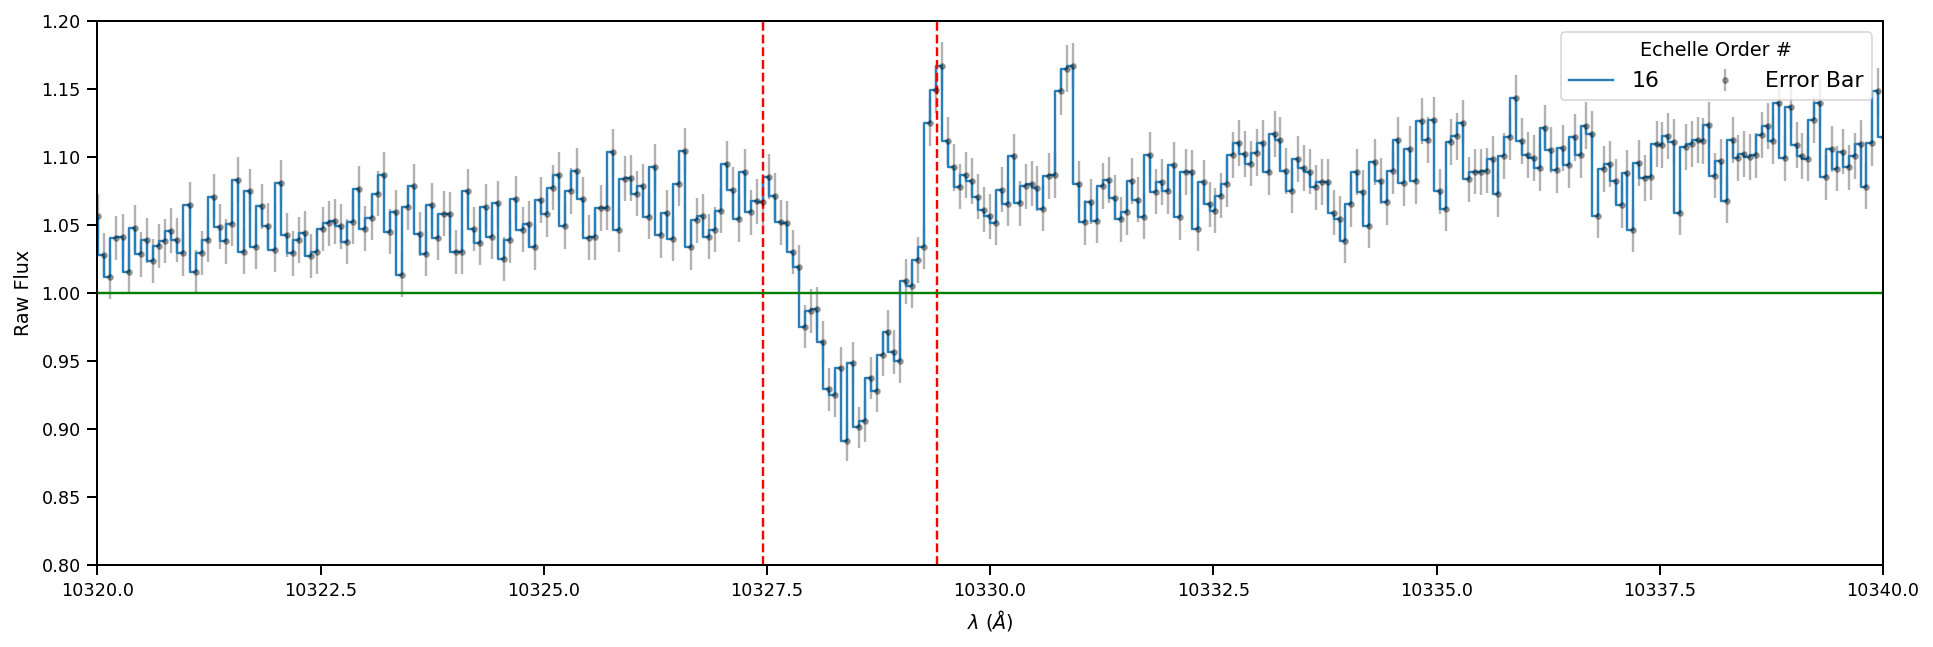

In [55]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(0.8,1.2)
plt.xlim(10820,10340)
wavelength1 = 10827.45
wavelength2 = 10829.4
continuum = 1
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

In [56]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10325) & (df['Sci Wavl'] < 10330)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [61]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0.04, 1, 0.15, 10328.55, np.log(0.38)

In [83]:
np.log(0.38)

-0.9675840262617056

In [62]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

In [78]:
unc.min()

0.015234145

(0.8, 1.2)

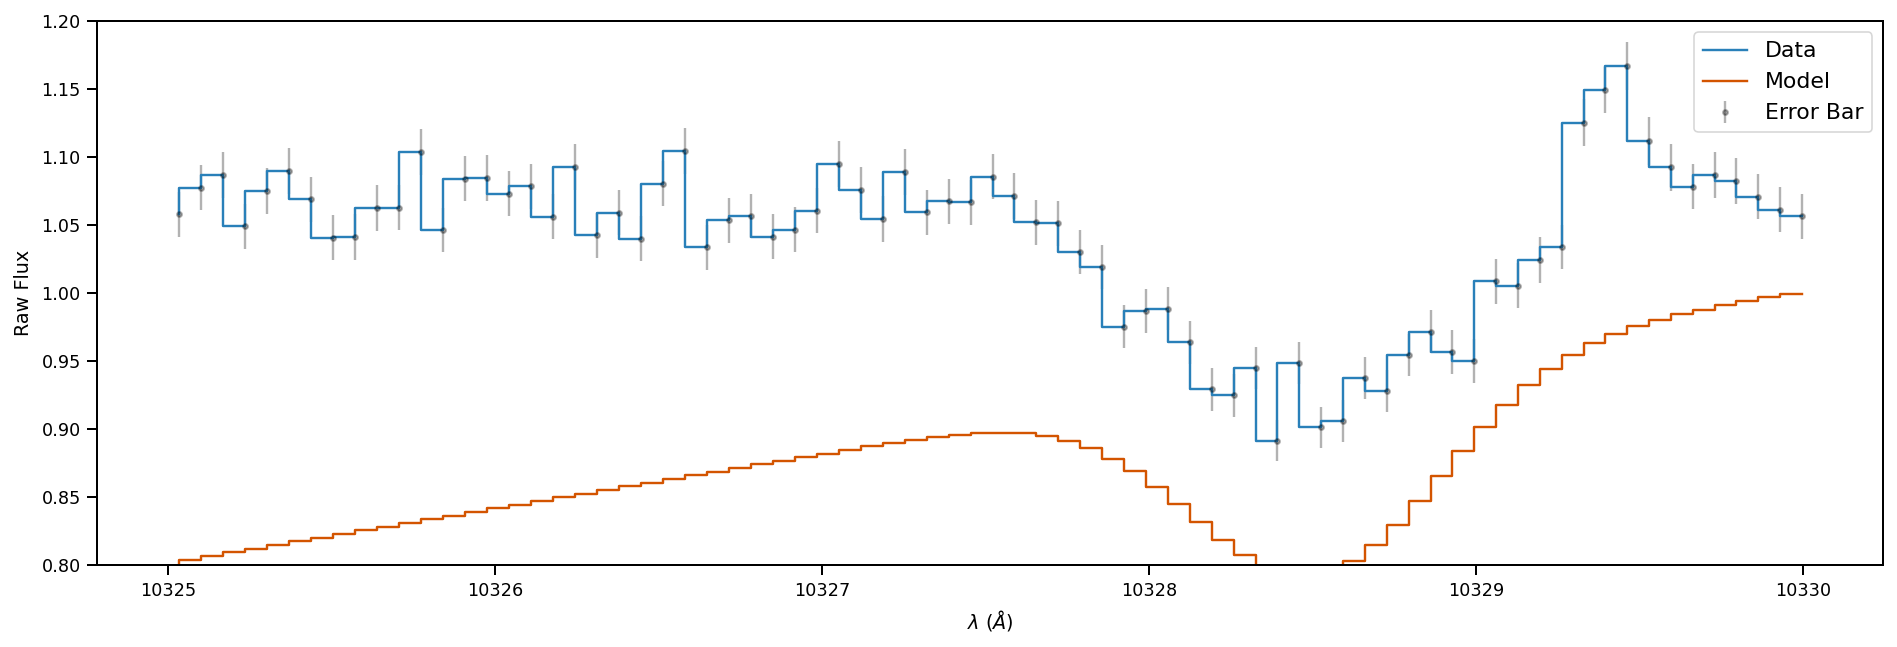

In [63]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(0.8,1.2)
plt.savefig('C:/Users/jojoa/GitHub/disperse/figures/MCMC_fig',bbox_inches="tight")

In [70]:
def log_likelihood(theta, int_wl = 10328.5):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = int_wl)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [71]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess)

-2047.339612048885

In [72]:
theta_guess

array([ 4.00000000e-02,  1.00000000e+00,  1.50000000e-01,  1.03285500e+04,
       -9.67584026e-01])

In [73]:
kwarg_dict = {'int_wl':10328.5}   

In [74]:
kwarg_dict

{'int_wl': 10328.5}

In [84]:
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)

In [85]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood,kwargs=kwarg_dict)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 149.01it/s]


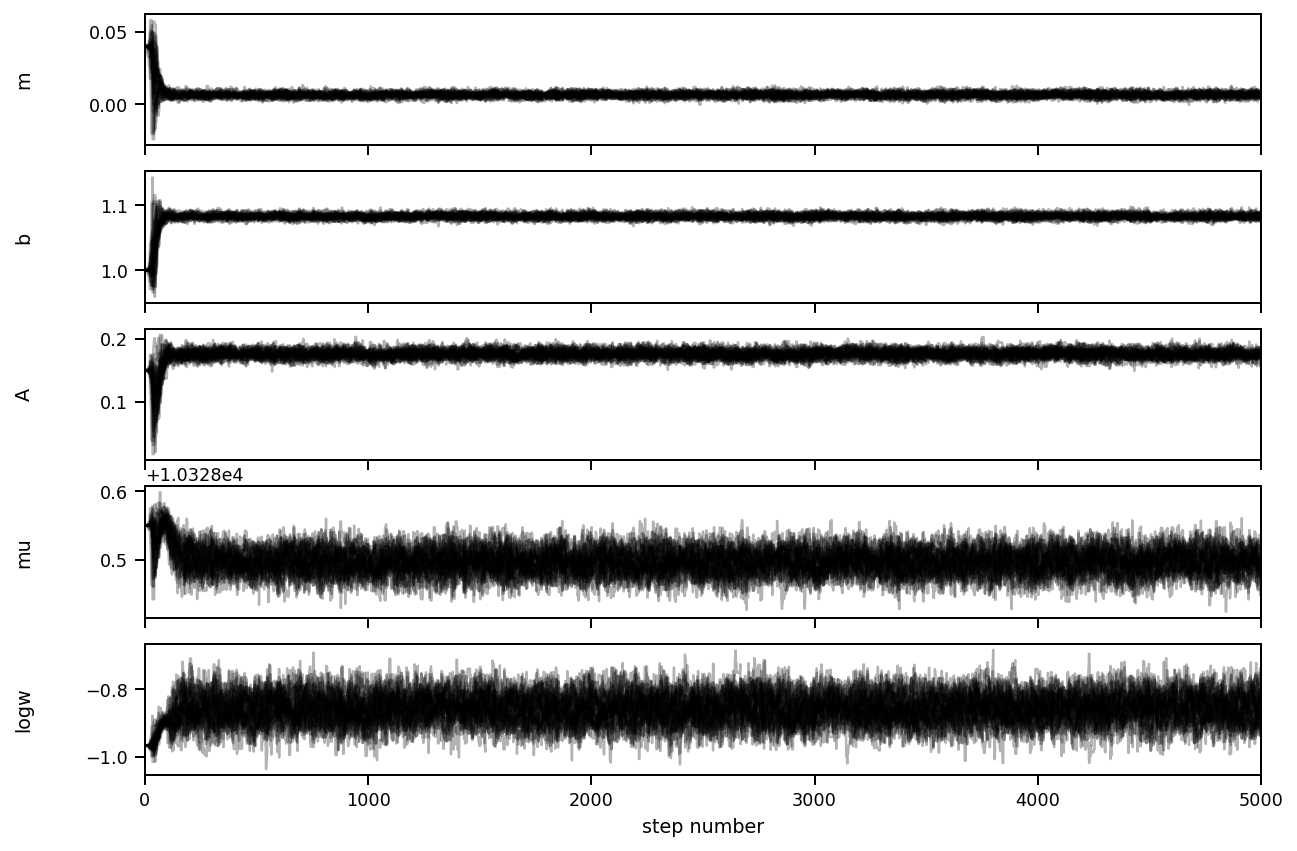

In [87]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "logw"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [88]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [90]:
import corner

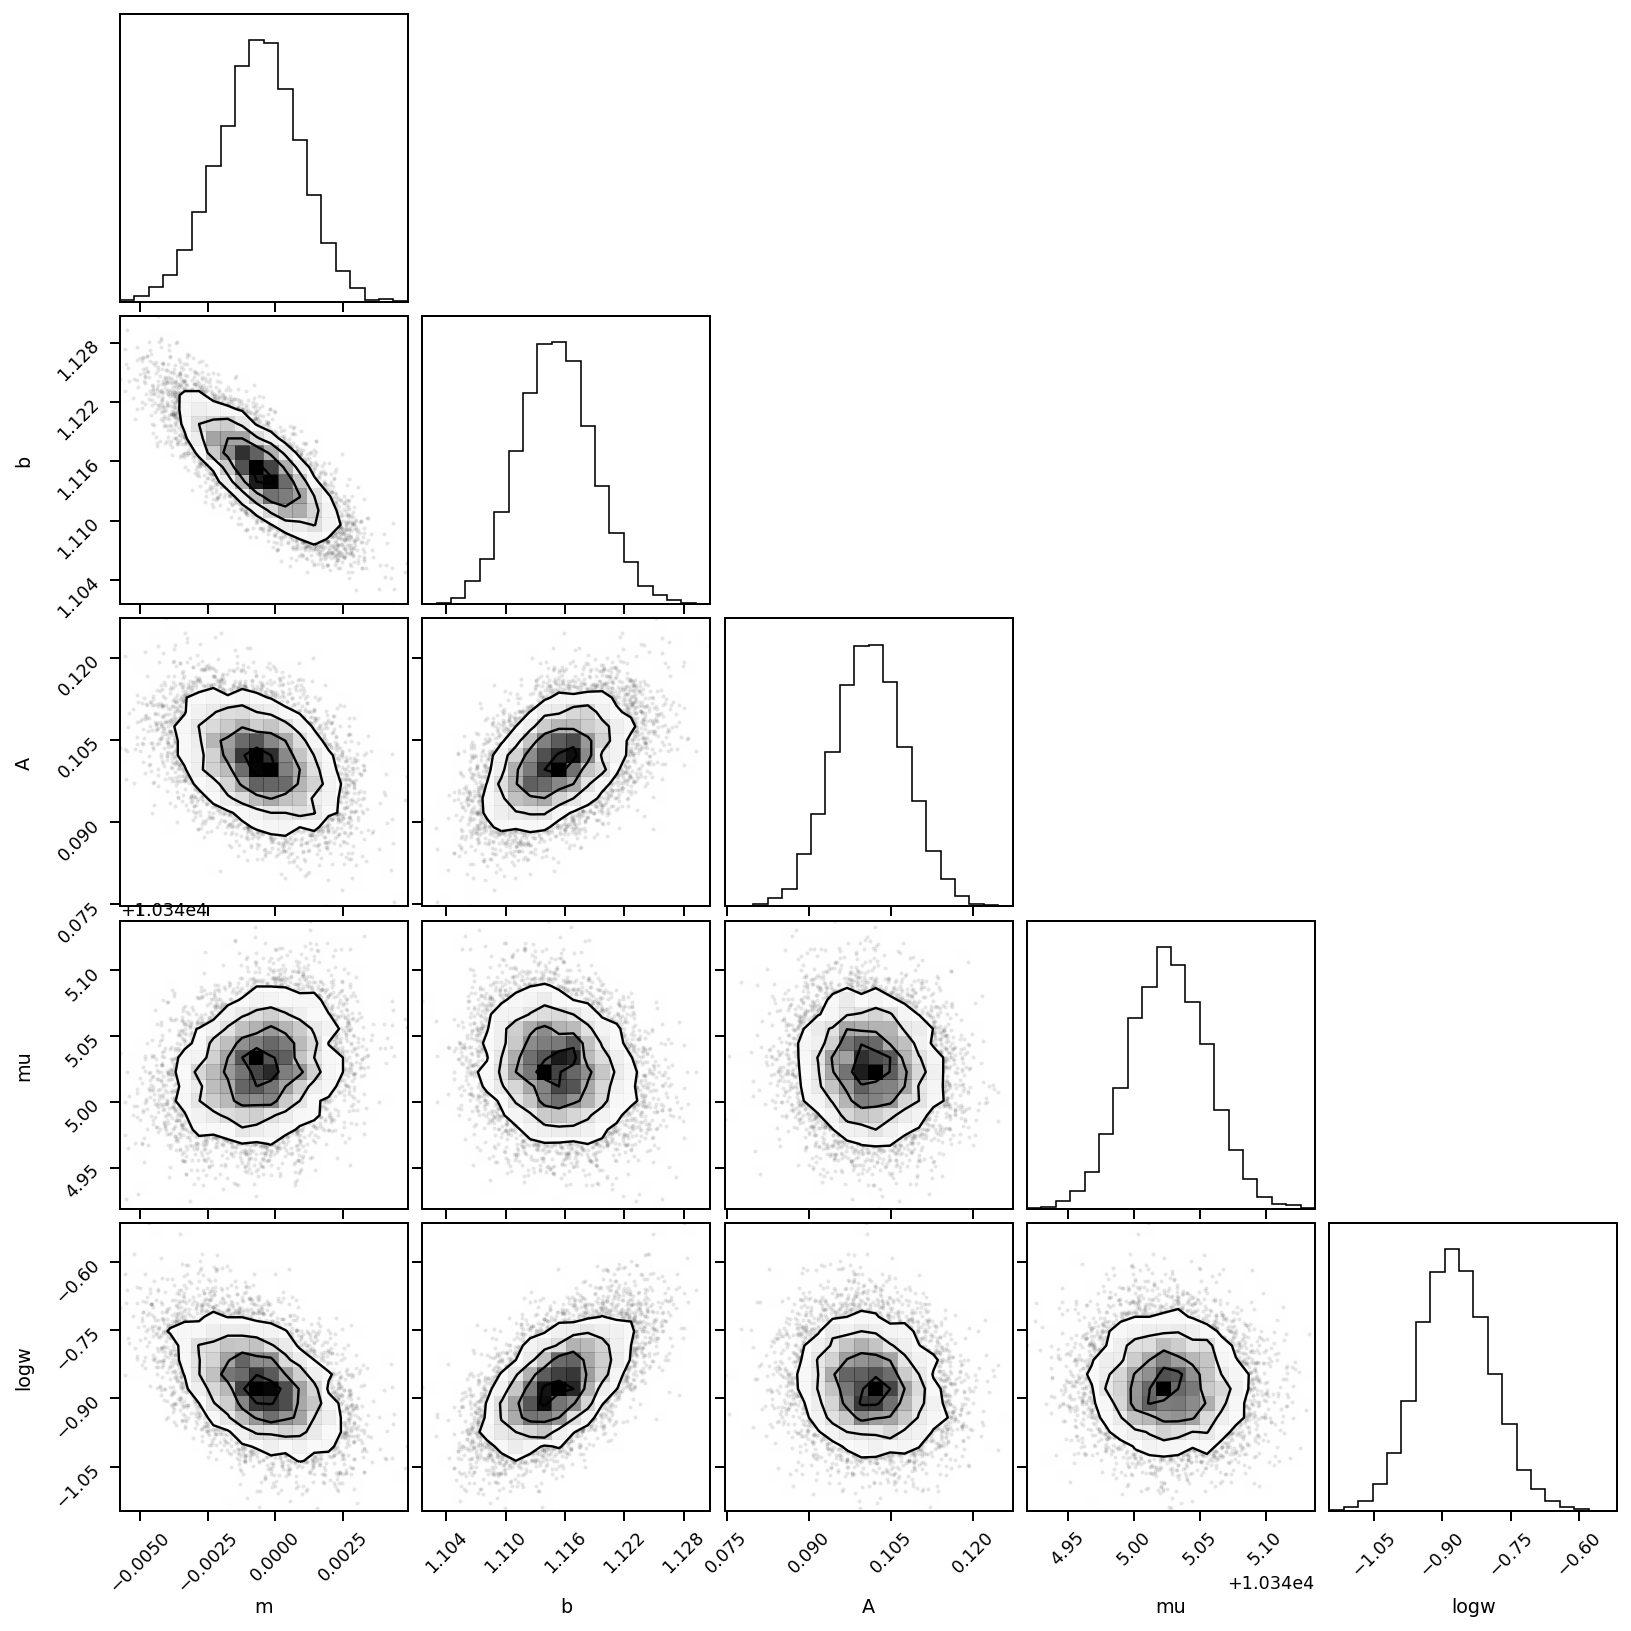

In [91]:
ax = corner.corner(flat_samples, labels=labels)